In [2]:
try:
    import setup
except:
    pass
from notebook_helper import *
import modules.viz
from popolo_data.importer import Popolo


# Party cohorts, Summer 2021

This notebook investigates the effect of a change from comparing current MPs to a score-per-party for each policy, to calculating a score for each unique cohort of MPs that share a party and membership periods.

The reason for this is that policies can span multiple parliaments, and so the aggregate position an MP may be being compared to includes votes they were not able to take part in. 

Reversals in position on a policy between Parliaments can then mean that an MP who is following the party line is identified as not following the party line.

The expected effect of this is that MPs should have less distance between their scores and the party score they are being compared to. This was confirmed, with the largest effects in most recent cohorts. One MP moving a long way in the opposite direction led to a change in the approach to avoid that.

## Method

Using a local instance of TheyWorkForYou, loaded with policy data from June 2021, the displayed policy information and part distance was scraped from all current MP pages. 

After making the change and re-running policy calculations, the same process was run again. The following analysis combines the two datasets, and calculates the change in the party distance (difference between the score for the MP and the score for the party they are compared to) between the two datasets. 

In [29]:
# get extra information from people.json to populate party and start date information
pop = Popolo.from_url("https://raw.githubusercontent.com/mysociety/parlparse/master/members/people.json")

memberships = list(pop.memberships)
memberships.sort(key=lambda x: x.start_date.earliest_date)
party_lookup = {}
for m in memberships:
    if m.person_id and m.on_behalf_of_id:
        party_lookup[int(m.person_id.split("/")[-1])] = m.on_behalf_of_id

memberships.sort(key=lambda x: x.start_date.earliest_date, reverse=True)
start_lookup = {}
for m in memberships: # cuts off at 1997 for convienence
    if m.person_id and m.on_behalf_of_id:
        start_lookup[int(m.person_id.split("/")[-1])] = m.start_date.earliest_date.year


In [30]:
# get the old and new party distances in the same dataframe
dfo = pd.read_csv(Path("data", "policy", "mp_policy_scores_baseline.csv"))
dfn = pd.read_csv(Path("data", "policy", "mp_policy_scores_party_cohort_2.csv"))

dfn = dfn[["policy-id", "policy-party-score-distance", "mp_id"]]
dfn = dfn.rename(columns={"policy-party-score-distance": "policy-party-score-distance-new"})
df = dfo.merge(dfn, on=["policy-id", "mp_id"])
df["change"] = df["policy-party-score-distance-new"] - df["policy-party-score-distance"]


In [37]:
# get the average policy change for each MP and add party and start_year
pt = df.pivot_table("change", index=["mp_id"], columns=None, aggfunc="mean").reset_index().sort_values("change")
pt["party"] = pt["mp_id"].map(party_lookup)
name_dict = df.set_index("mp_id")["mp_name"].to_dict()
pt["name"] = pt["mp_id"].map(name_dict)
pt["start_year"] = pt["mp_id"].map(start_lookup)

# Effect on all MPs

The following [raincloud plot](https://wellcomeopenresearch.org/articles/4-63) shows that on average there is a slight decrease in the average distance between the MP and the Party. There is a clump of MPs with a decrease of around 0.4, with another set around -0.6 to 0.7.

There are a small amount of MPs who have an increase in the party distance, with two outliers with a large increase in party distance. 

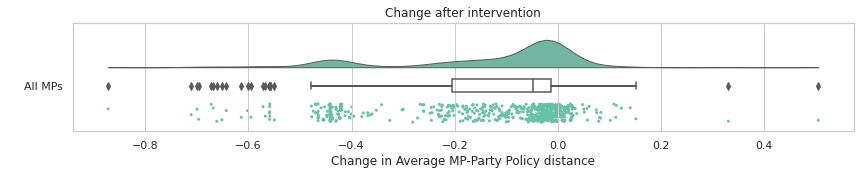

In [32]:
pt["change"].viz.raincloud(title="Change after intervention", all_data_label="All MPs", x_label="Change in Average MP-Party Policy distance")

# MPs with increased distances

The following MPs are the ten who had their similarlity with their party decrease after the change.

In [38]:
t = pt.tail(10).sort_values("change", ascending=False)

t[["name", "party", "start_year", "change"]].style.hide_index()

name,party,start_year,change
lindsay_hoyle,speaker,1997,0.51
neale_hanvey,alba,2019,0.33
preet_kaur_gill,labourco-operative,2017,0.15
alistair_carmichael,liberal-democrat,2001,0.14
mohammad_yasin,labour,2017,0.12
carla_lockhart,dup,2016,0.11
matt_rodda,labour,2017,0.11
dan_carden,labour,2017,0.11
janet_daby,labour,2018,0.10
colleen_fletcher,labour,2015,0.08


Generally these distances are small and will be explained by the overall party record in one or two policies being more similar to this MPs record than the record of their cohort. The two large changes that needed more investigation were for Lindsay Hoyle (the current speaker) and Neale Hanvey (A SNP MP who moved to Alba).

As party comparison information is suppressed for single member parties like the speaker, this distance doesn't matter, but is explained by the fact that while the speaker didn't take part in votes, they did take part in votes in the past when there *was* a different speaker, and these votes are now highlighted as a difference from the party record when they weren't before. This highlights the complexity of handling party change information, but in this case there is no difference in what is displayed to the user. 

In Neale Hanvey's case he was being compared as a member of a one person party, whereas the new approach compared him to the SNP record with a disclaimer they are being compared to their original party. Because they are moving from an effective difference to the party of 0, the change appears large.

A previous iteration also indicated a change for [Jeffrey M. Donaldson](https://www.theyworkforyou.com/mp/10172/jeffrey_m._donaldson/lagan_valley). This resulted from a change in how party-switchers were being compared (from current to original party). As this MP switched parties in 2003, the majority of his voting history is covered by his new party, and so he was added to a group of party-switchers that are compared to their current party. 

# Effect of election cohort

The following raincloud plot seperates MPs by election year (excluding those first elected in by-elections to simplify). This shows that the MPs who will be most effected (and moved closer to the party position) are those elected more recently. This makes sense, as the primary issue is judging MPs against divisions they were not able to take part in. 



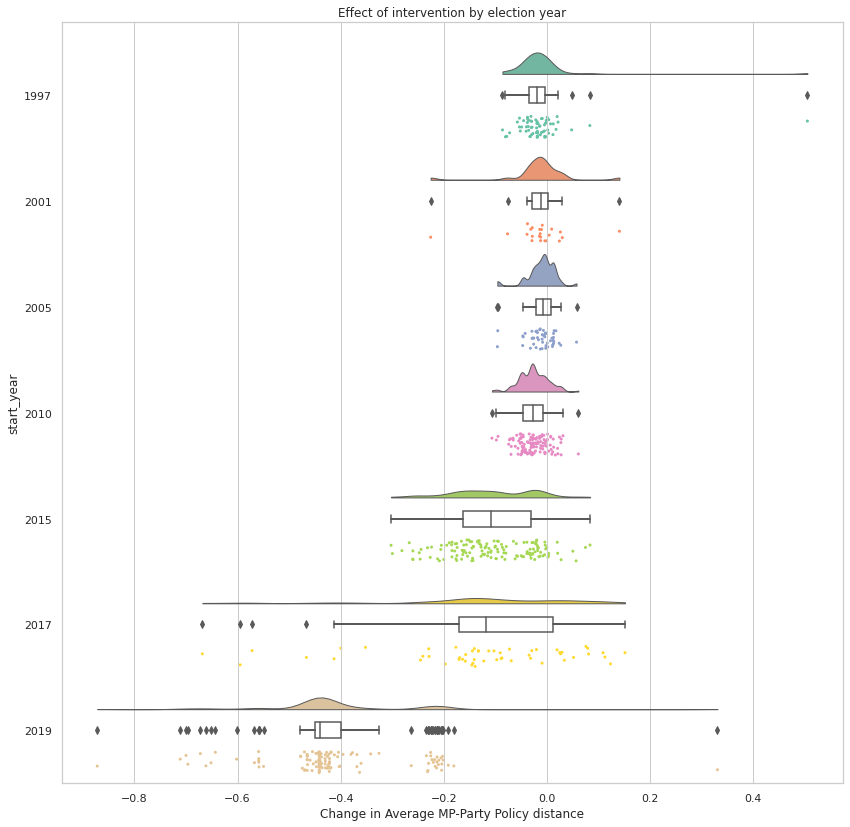

In [39]:
election_years = [1997, 2001, 2005, 2010, 2015, 2017, 2019]

(pt
.loc[pt["start_year"].isin(election_years)]
.viz.raincloud("change", "start_year", title="Effect of intervention by election year", all_data_label="All MPs", x_label="Change in Average MP-Party Policy distance")
)


## Effect by party

Plotting by party cohort shows a special effect for the Lberal Democrats as so many MPs were elected in a recent cohort. Generally patterns are better expressed as a result of the election year rather than party.

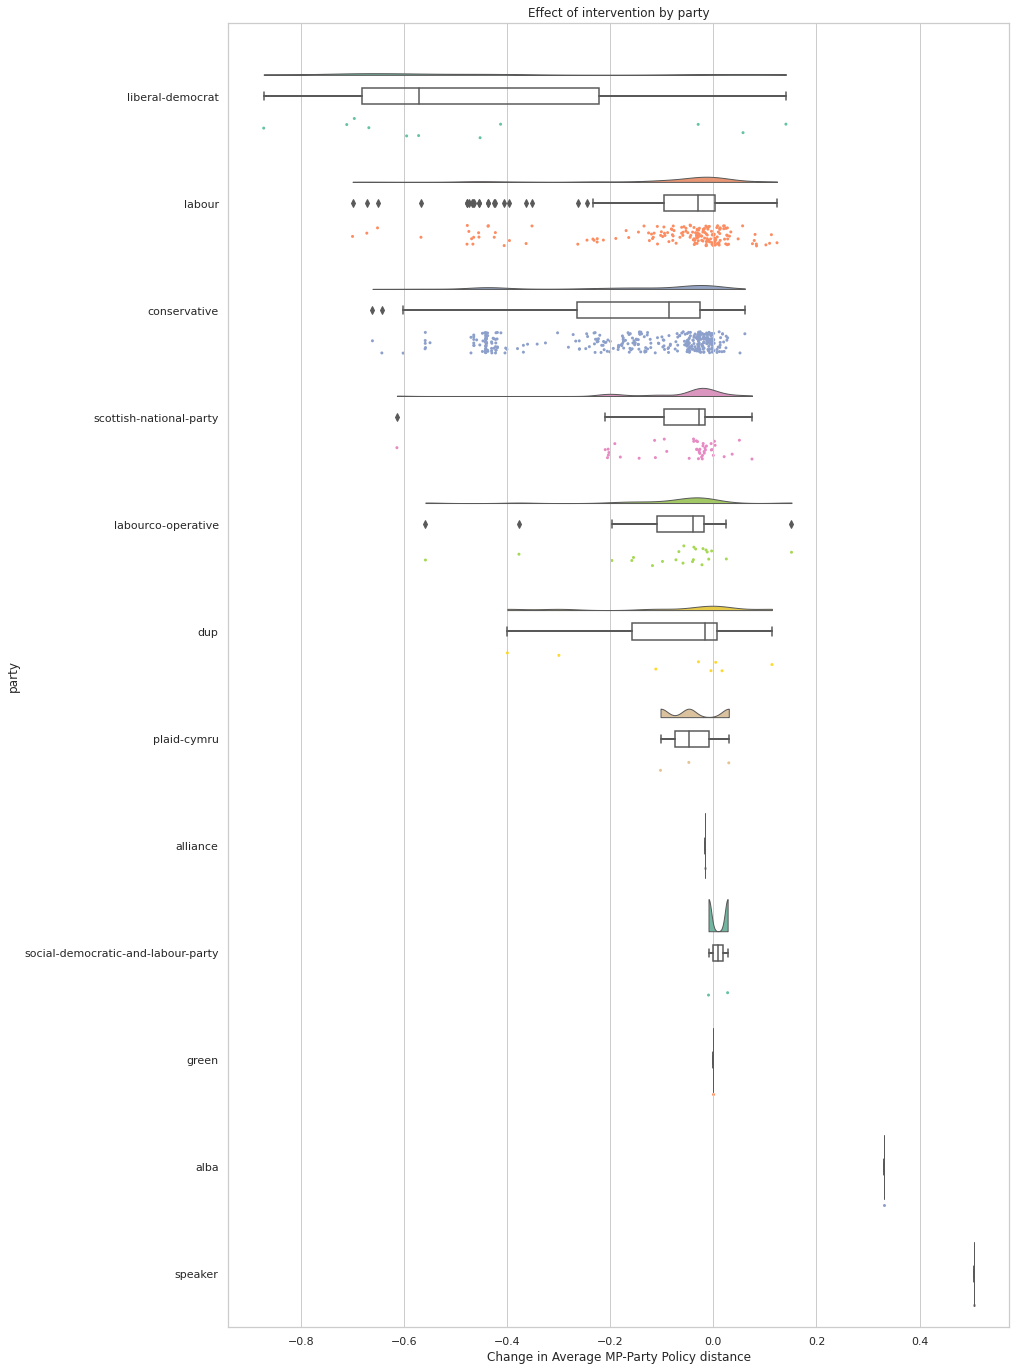

In [42]:
(pt
.viz.raincloud("change", "party", title="Effect of intervention by party", all_data_label="All MPs", x_label="Change in Average MP-Party Policy distance")
)

## Effect on policy areas

Policies are grouped into different areas. Averaging out the change found this change had the largest effect in moving foreign policy positions closer to the party position. This is not a large change. 

In [35]:
pt = (df
      .pivot_table("change", index=["policy-group"], columns=None, aggfunc="mean")
      .reset_index()
      .sort_values("change"))
pt.style.format({"change":'{0:,.3f}'}).hide_index()


policy-group,change
foreignpolicy,-0.127
misc,-0.084
business,-0.083
education,-0.079
reform,-0.077
taxation,-0.051
environment,-0.042
home,-0.024
social,-0.023
transport,-0.015


# Conclusion

The planned intervention has the expected effect of moving MPs closer to the party and reducing the number of differences highlighted. The effect will be largest for more recent cohorts. 

The review process discovered an outlier (Donaldson) whose party record would become harder to interpret as a result of the change. This was addressed by a change to the process.

In [6]:
render_to_markdown(Path("notebooks", "2021_09_voting_cohorts.ipynb"),
                   Path("rendered_notebooks", "2021_09_voting_cohorts.md"),
                   clear_and_execute=False)


writing: rendered_notebooks/_notebook_resources/2021_09_voting_cohorts_6_0.png
writing: rendered_notebooks/_notebook_resources/2021_09_voting_cohorts_11_0.png
writing: rendered_notebooks/_notebook_resources/2021_09_voting_cohorts_13_0.png
Written to rendered_notebooks/2021_09_voting_cohorts.md at 2021-09-30 16:10:06.010371
